# Life time Calculation 

This Notebook shows a general calculation stream the rainflow calculation. If you have any question feel free to contact [us](mailto:DanielChristopher.Kreuter@de.bosch.com).

In [1]:
import numpy as np
import pandas as pd

import pylife.stress.histogram as psh
import pylife.stress.timesignal as ts
import pylife.stress.rainflow as RF
import pylife.stress.rainflow.recorders as RFR


import pyvista as pv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy import signal as sg

# mpl.style.use('seaborn')
mpl.style.use('bmh')
get_ipython().run_line_magic('matplotlib', 'inline')

some functionality to plot the rainflow matrices

In [17]:
def plot_rf(rf_series_dict):
    fig = plt.figure(figsize=(12, 20))
    cmap = cm.get_cmap('jet') # 
    for ii, key in enumerate(rf_series_dict.keys()):
        rf_series = rf_series_dict[key]
        ax = fig.add_subplot(1,len(rf_series_dict),ii + 1, projection='3d')
        
        froms = rf_series.index.get_level_values("from").mid
        tos = rf_series.index.get_level_values("to").mid
        
        width = rf_series.index.get_level_values('from').length.min()
        depth = rf_series.index.get_level_values('to').length.min()
        bottom = np.zeros_like(rf_series)
        
        max_height = np.max(rf_series) 
        min_height = np.min(rf_series)
        rgba = [cmap((k-min_height)/max_height) for k in rf_series] 
        ax.set_xlabel('From')
        ax.set_ylabel('To')
        ax.set_zlabel('Count')
        ax.bar3d(froms.ravel(), tos.ravel(), bottom, width, depth, rf_series, 
                 color=rgba, shade=True, zsort='average')
        ax.set_title(key)
    return fig

### Time series signal ###
import, filtering and so on. You can import your own signal with

* [pd.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
* [pd.read_excel()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html)
* [scipy.io.loadmat()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) for matlab files 

and so on

<AxesSubplot:xlabel='frequency', ylabel='PSD'>

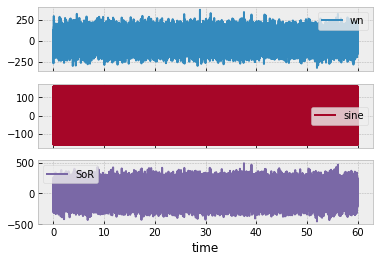

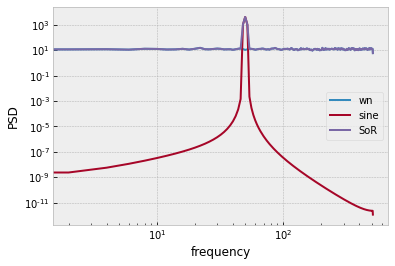

In [4]:
np.random.seed(4711)
sample_frequency = 1024
t = np.linspace(0, 60, 60 * sample_frequency)
signal_df = pd.DataFrame(data = np.array([80 * np.random.randn(len(t)),
                                          160 * np.sin(2 * np.pi * 50 * t)]).T,
                         columns=["wn", "sine"],
                         index=pd.Index(t, name="time"))
signal_df["SoR"] = signal_df["wn"] + signal_df["sine"]
signal_df.plot(subplots=True)
ts.psd_df(signal_df, NFFT = 512).plot(loglog=True, ylabel="PSD")

### Filtering 

In [5]:
f_min = 5.0    # Hz
f_max = 100.0  # Hz

<AxesSubplot:xlabel='frequency', ylabel='PSD bandpassed'>

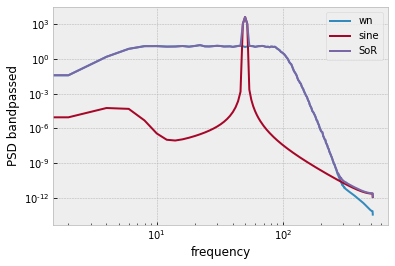

In [8]:
bandpass_df = ts.butter_bandpass(signal_df, f_min, f_max)

df_psd = ts.psd_df(bandpass_df, NFFT = 512)
df_psd.plot(loglog=True, ylabel="PSD bandpassed")

### Running statistics

First we create a spike in our existing data set

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

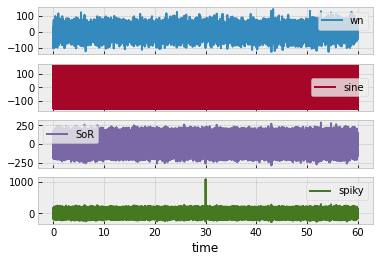

In [12]:
bandpass_df["spiky"] = bandpass_df["SoR"] + 1e3 * sg.unit_impulse(signal_df.shape[0], idx="mid")
bandpass_df.plot(subplots=True)

Now we want to clean this spike automatically

C:\python\pyLife\_venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
Feature Extraction: 100%|████████████████████████████████████████████████████████| 1364/1364 [00:00<00:00, 8439.95it/s]


<AxesSubplot:xlabel='frequency', ylabel='PSD_cleaned'>

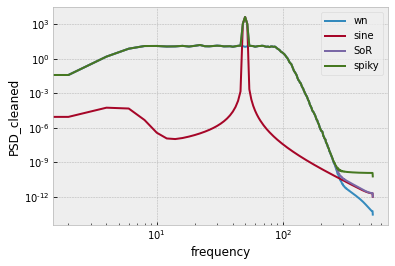

In [23]:
cleaned_df = ts.clean_timeseries(bandpass_df, "spiky", window_size=200, overlap=20,
                     feature="abs_energy", n_gridpoints=3,
                     percentage_max=0.05, order=3).drop(["time"], axis=1)

ts.psd_df(cleaned_df, NFFT = 512).plot(loglog=True, ylabel="PSD_cleaned" )

### Rainflow ###

In [ ]:
rainflow_bins = 64

In [14]:
#%% Rainflow for a multiple time series
recorder_dict = {key: RFR.FullRecorder() for key in cleaned_df}
detector_dict = {key: RF.FKMDetector(recorder=recorder_dict[key]).process(cleaned_df[key]) for key in cleaned_df}
rf_series_dict = {key: detector_dict[key].recorder.matrix_series(10) for  key in detector_dict.keys()}

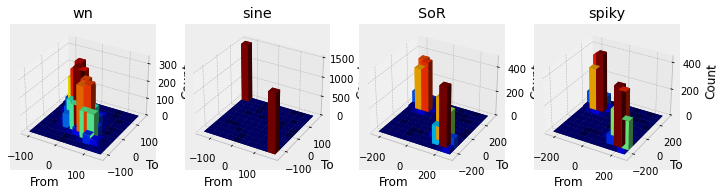

In [18]:
f = plot_rf(rf_series_dict)

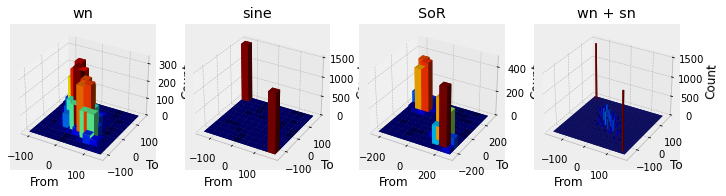

In [21]:
#%% Now Combining different RFs to one
rf_series_dict["wn + sn"] = psh.combine_hist([rf_series_dict["wn"],rf_series_dict["sine"]],
                                             method="sum")
f = plot_rf(rf_series_dict)

### PSD combinig
It is also possible to combine spectra

<AxesSubplot:xlabel='frequency', ylabel='PSD max'>

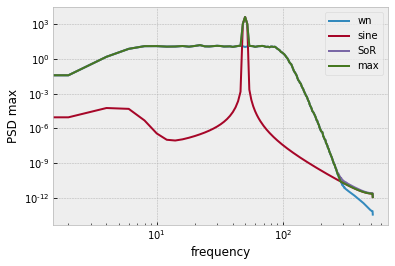

In [24]:
df_psd["max"] =  df_psd[["sine", "wn"]].max(axis = 1)
df_psd.plot(loglog=True, ylabel="PSD")